In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import skimage
from skimage.viewer import ImageViewer
from matplotlib import pyplot as plt
import random
from scipy.ndimage import rotate
import numpy as np
import cv2
import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


In [2]:
import random
def rotate_img(img, angle, bg_patch=(10,10)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img
def distort(img, func, orientation='horizontal', x_scale=0.1, y_scale=5):
    assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()
    
    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
        for i in range(img.shape[orientation.startswith('ver')]):
            if orientation.startswith('ver'):
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
    return img_dist
def translate(img, shift=5, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img

def change_channel_ratio (img, divisor, channel):
    channel=random.choice(["r","g","b"])
    divisor = random.randint(4,7)
    assert channel in 'rgb', "Value for channel: r|g|b"
    img = img.copy()
    ci = 'rgb'.index(channel)
    img[:, :, ci] = (divisor-1)*(img[:, :, ci]/divisor)
    return img


In [3]:
def hair(img):
        n_hairs = random.randint(0, 5)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir("../input/asdf1123/melanoma-hairs") if 'png' in im]

        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join("../input/asdf1123/melanoma-hairs", random.choice(hair_images)))
            b,g,r = cv2.split(hair)           # get b, g, r
            hair = cv2.merge([r,g,b]) # convert to rgb
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10,255,cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)
            
            
            
            dst = cv2.add(img_bg, hair_fg)
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img

In [4]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
X = np.load('../input/siimisic-melanoma-resized-images/x_train_128.npy')

In [6]:
import gc
train["image"] = None
for i in range (len(train["image"])):
    train["image"][i] = X[i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


preparing df for loading npy image 

In [7]:
train = train.sample(frac=1)

In [8]:
lists = np.array_split(train, 5)

In [9]:
train = pd.concat(lists[0:4], ignore_index=True, sort=False)
test = lists[4]
print(train.shape)
print(test.shape)

(26501, 9)
(6625, 9)


In [10]:
melanoma_ones = train['target']==1
melanoma_df = train[melanoma_ones]

melanoma_df_rotated = melanoma_df.copy()
for i in range (len(melanoma_df_rotated["image"])):
    melanoma_df_rotated["image"].iloc[i] = rotate_img(melanoma_df_rotated["image"].iloc[i],90)
melanoma_df_rotated['target'] = 1
train = pd.concat([train, melanoma_df_rotated], ignore_index=True, sort=False)

melanoma_df_rotated = melanoma_df.copy()
for i in range (len(melanoma_df_rotated["image"])):
    melanoma_df_rotated["image"].iloc[i] = rotate_img(melanoma_df_rotated["image"].iloc[i],180)
melanoma_df_rotated['target'] = 1
train = pd.concat([train, melanoma_df_rotated], ignore_index=True, sort=False)

melanoma_df_rotated = melanoma_df.copy()
for i in range (len(melanoma_df_rotated["image"])):
    melanoma_df_rotated["image"].iloc[i] = rotate_img(melanoma_df_rotated["image"].iloc[i],270)
melanoma_df_rotated['target'] = 1
train = pd.concat([train, melanoma_df_rotated], ignore_index=True, sort=False)

melanoma_ones = test['target']==1
melanoma_df = test[melanoma_ones]

melanoma_df_rotated = melanoma_df.copy()
for i in range (len(melanoma_df_rotated["image"])):
    melanoma_df_rotated["image"].iloc[i] = rotate_img(melanoma_df_rotated["image"].iloc[i],90)
melanoma_df_rotated['target'] = 1
test = pd.concat([test, melanoma_df_rotated], ignore_index=True, sort=False)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
train.shape

(27863, 9)

In [12]:
benign_train = train['target']==0
benign_train_df = train[benign_train]

benign_train_df_aug = benign_train_df.copy()
for i in range (len(benign_train_df_aug["image"])):
    if i % 5 == 1:
        benign_train_df_aug["image"].iloc[i] = translate(benign_train_df_aug["image"].iloc[i],direction = random.choice(['up','down','left','right']))
    elif i% 5 == 2:
        benign_train_df_aug["image"].iloc[i] = distort(benign_train_df_aug["image"].iloc[i],func=np.sin,x_scale=random.uniform(0.02,0.08))
    elif i%5 == 3:
        benign_train_df_aug["image"].iloc[i] = change_channel_ratio(benign_train_df_aug["image"].iloc[i],divisor=1,channel="r")
    elif i%5 == 4:
        benign_train_df_aug["image"].iloc[i] = hair(benign_train_df_aug["image"].iloc[i])
benign_train_df_aug['target'] = 0
train = pd.concat([train, benign_train_df_aug], ignore_index=True, sort=False)

notbenign_train = train['target']==1
notbenign_train_df = train[notbenign_train]

notbenign_train_df_aug = notbenign_train_df.copy()
for i in range (len(notbenign_train_df_aug["image"])):
    if i % 5 == 1:
        notbenign_train_df_aug["image"].iloc[i] = translate(notbenign_train_df_aug["image"].iloc[i],direction = random.choice(['up','down','left','right']))
    elif i% 5 == 2:
        notbenign_train_df_aug["image"].iloc[i] = distort(notbenign_train_df_aug["image"].iloc[i],func=np.sin,x_scale=random.uniform(0.02,0.08))
    elif i%5 == 3:
        notbenign_train_df_aug["image"].iloc[i] = change_channel_ratio(notbenign_train_df_aug["image"].iloc[i],divisor=1,channel="r")
    elif i%5 == 4:
        notbenign_train_df_aug["image"].iloc[i] = hair(notbenign_train_df_aug["image"].iloc[i])
benign_train_df_aug['target'] = 1
train = pd.concat([train, notbenign_train_df_aug], ignore_index=True, sort=False)


In [13]:
train.shape

(55726, 9)

In [14]:
test.shape

(6755, 9)

In [15]:
gc.collect()

60

In [16]:
train = train.sample(frac=1)
test = test.sample(frac=1)
print(train.shape)
print(test.shape)

(55726, 9)
(6755, 9)


In [17]:
train = train.sample(frac=1)
test = test.sample(frac=1)
notbenign_train = train['target']==1
notbenign_train_df = train[notbenign_train]

notbenign_train_df_aug = notbenign_train_df.copy()
for i in range (len(notbenign_train_df_aug["image"])):
    if i % 5 == 1:
        notbenign_train_df_aug["image"].iloc[i] = translate(notbenign_train_df_aug["image"].iloc[i],direction = random.choice(['up','down','left','right']))
    elif i% 5 == 2:
        notbenign_train_df_aug["image"].iloc[i] = distort(notbenign_train_df_aug["image"].iloc[i],func=np.sin,x_scale=random.uniform(0.02,0.08))
    elif i%5 == 3:
        notbenign_train_df_aug["image"].iloc[i] = change_channel_ratio(notbenign_train_df_aug["image"].iloc[i],divisor=1,channel="r")
    else:
        notbenign_train_df_aug["image"].iloc[i] = hair(notbenign_train_df_aug["image"].iloc[i])
benign_train_df_aug['target'] = 1
train = pd.concat([train, notbenign_train_df_aug], ignore_index=True, sort=False)


print(train.shape)
print(test.shape)

(59358, 9)
(6755, 9)


In [18]:
train.shape

(59358, 9)

In [19]:
train = train.sample(frac=1)
test = test.sample(frac=1)
notbenign_train = train['target']==1
notbenign_train_df = train[notbenign_train]

notbenign_train_df_aug = notbenign_train_df.copy()
for i in range (len(notbenign_train_df_aug["image"])):
    if i % 5 == 1:
        notbenign_train_df_aug["image"].iloc[i] = translate(notbenign_train_df_aug["image"].iloc[i],direction = random.choice(['up','down','left','right']))
    elif i% 5 == 2:
        notbenign_train_df_aug["image"].iloc[i] = distort(notbenign_train_df_aug["image"].iloc[i],func=np.sin,x_scale=random.uniform(0.02,0.08))
    elif i%5 == 3:
        notbenign_train_df_aug["image"].iloc[i] = change_channel_ratio(notbenign_train_df_aug["image"].iloc[i],divisor=1,channel="r")
    else:
        notbenign_train_df_aug["image"].iloc[i] = hair(notbenign_train_df_aug["image"].iloc[i])
benign_train_df_aug['target'] = 1
train = pd.concat([train, notbenign_train_df_aug], ignore_index=True, sort=False)


print(train.shape)
print(test.shape)

(66622, 9)
(6755, 9)


In [20]:
train['image'].iloc[0].shape

(128, 128, 3)

add hair augmentation

In [21]:
train = train.sample(frac=1)
test = test.sample(frac=1)

#numpyarray = train[["image", "age_approx"]].to_numpy()
numpyarray = []
for i in range (len(train["image"])):
    z=train["image"].iloc[i]
    numpyarray.append(z)

X_train = np.array(numpyarray)
y_train = train['target'].values

#numpyarray = test[["image", "age_approx"]].to_numpy()
numpyarray = []
for i in range (len(test["image"])):
    z=test["image"].iloc[i]
    numpyarray.append(z)

X_test = np.array(numpyarray)
y_test = test['target'].values


In [22]:
gc.collect()

100

In [23]:
X_train[0].shape[0]

128

In [24]:
del benign_train_df_aug
del notbenign_train_df_aug
del X
del train
del test
gc.collect()

40

In [25]:
del numpyarray
del z
gc.collect()

20

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66622, 128, 128, 3)
(66622,)
(6755, 128, 128, 3)
(6755,)


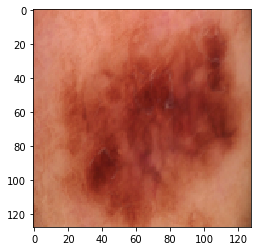

In [27]:
from matplotlib import pyplot as plt
plt.imshow(X_train[100], interpolation='nearest')
plt.show()

In [28]:
from keras.layers import Activation
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(128, 128,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

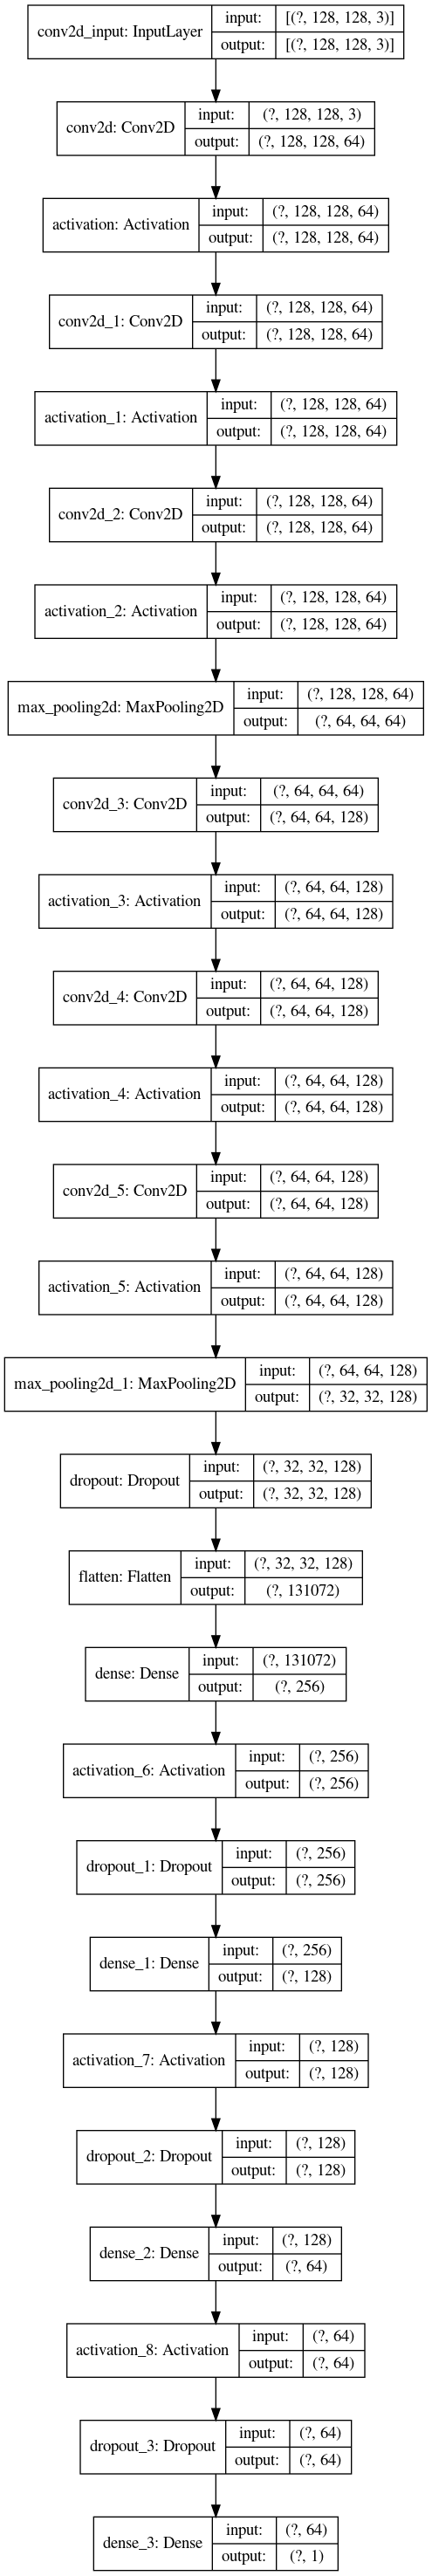

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [31]:
gc.collect()
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
2082/2082 [==============================] - 146s 70ms/step - loss: 0.4848 - accuracy: 0.8372 - val_loss: 0.1313 - val_accuracy: 0.9679
Epoch 2/5
2082/2082 [==============================] - 146s 70ms/step - loss: 0.2361 - accuracy: 0.9135 - val_loss: 0.1301 - val_accuracy: 0.9694
Epoch 3/5
2082/2082 [==============================] - 146s 70ms/step - loss: 0.1795 - accuracy: 0.9378 - val_loss: 0.1125 - val_accuracy: 0.9714
Epoch 4/5
2082/2082 [==============================] - 145s 70ms/step - loss: 0.1470 - accuracy: 0.9507 - val_loss: 0.1191 - val_accuracy: 0.9719
Epoch 5/5
2082/2082 [==============================] - 146s 70ms/step - loss: 0.1167 - accuracy: 0.9624 - val_loss: 0.1011 - val_accuracy: 0.9760


In [32]:
gc.collect()

4319

In [33]:
gc.collect()

20

In [34]:
model.save('trained_model9.h5')

In [35]:
X_testing = np.load('../input/siimisic-melanoma-resized-images/x_test_128.npy')
prediction = model.predict_proba(X_testing)

In [36]:
prediction[0:50]

array([[1.42417179e-04],
       [4.42505143e-06],
       [6.10319688e-08],
       [1.32626310e-05],
       [2.75930651e-02],
       [1.79992593e-03],
       [8.70564778e-04],
       [7.25762472e-02],
       [1.84059203e-01],
       [9.20181221e-04],
       [4.35696961e-03],
       [1.03715217e-06],
       [6.81155324e-02],
       [1.71837164e-03],
       [3.65537703e-02],
       [5.42622820e-06],
       [4.71609150e-04],
       [2.66836607e-04],
       [4.11973707e-02],
       [5.18749617e-02],
       [3.76619138e-02],
       [1.48607884e-03],
       [9.18584466e-02],
       [1.01635046e-03],
       [1.32436082e-01],
       [9.83794685e-04],
       [2.00903310e-06],
       [1.29471971e-07],
       [1.41286966e-03],
       [2.82039346e-05],
       [1.52150926e-04],
       [7.20159079e-08],
       [5.70998117e-02],
       [3.62285972e-02],
       [1.03436284e-01],
       [3.04387487e-03],
       [1.58478622e-03],
       [1.55902609e-01],
       [3.30385410e-06],
       [1.00361621e-02],


In [37]:
results = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
results['target'] = prediction
results.to_csv('sample_cnn.csv', header=True, index=False)

In [38]:
for i in range (len(results['target'])):
    if results['target'].iloc[i] > 0.5:
        results['target'].iloc[i] += 0.04

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
results.to_csv('sample_cnn_boosted.csv', header=True, index=False)